
- densenet/resnet-inception/inceptionv4 apply
-  resnet/inceptions: with smaller parameters



In [2]:
import os
from glob import glob
import numpy as np
import nibabel as nib
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score
import tqdm
from operator import add
import matplotlib.pyplot as plt
import easydict

In [3]:
import wandb

!wandb login

wandb: Currently logged in as: tonge (use `wandb login --relogin` to force relogin)


In [4]:
# os.getcwd()
!pwd

/home/chaeeun/Desktop/brain disease prediction


In [5]:
data = np.load('./sliced_datas/sliced_2.npy')

In [6]:
def normalize(label):
    for i in range(5):
        y = label[:, i]
        label[:, i] = (y - y.mean())/y.std()

In [7]:
def unnorm_norm(ans):
    if ans == 'unnorm':
        label = np.load('./labels/unnorm_label.npy')
    else:
        label = np.load('./labels/normed_label.npy')
    return label

In [8]:
unnorm_label = unnorm_norm('unnorm')
norm_label = unnorm_norm('norm')

In [9]:
type(unnorm_label[0]), type(norm_label[0])

(numpy.ndarray, numpy.ndarray)

In [10]:
norm_label = np.array(norm_label, dtype = 'float32')
unnorm_label = np.array(unnorm_label, dtype = 'float32')
len(norm_label)
len(unnorm_label)

100

In [11]:
X_train = data[:75]
X_test = data[75:]
y_train = norm_label[:75]
y_test = norm_label[75:]
#y_train = unnorm_label[:75]
# y_test = unnorm_label[75:]

In [12]:
datadict = {
    'X_train': X_train, 
    'y_train' : y_train,
    'X_test': X_test,
    'y_test': y_test
}

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
class mridataset(Dataset):
    def __init__(self, data, data_type):
        if data_type == 'train':
            self.X = data['X_train']
            self.y = data['y_train']
        elif data_type == 'test':
            self.X = data['X_test']
            self.y = data['y_test']
            
        assert len(self.X) == len(self.y), "length should be same between input and label"
        
        self.X = torch.FloatTensor(self.X)#cpu tensor
        self.y = torch.FloatTensor(self.y)#cpu tensor
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return {
            'X': X,
            'y_target': y
        }

In [32]:
# from model.resnet import *
# model =  generate_model(50)
# model.to(device)

from model.densenet import densenet
model = densenet(121)
model.to(device)

/home/chaeeun/Desktop/brain disease prediction/model/densenet.py:132: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


DenseNet(
  (features): Sequential(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_s

# MODEL-inception_resnet_v2

In [17]:
# from model.inception_resnet_v2 import Inception_ResNetv2
# from model.inceptionv4 import Inceptionv4
# model = Inceptionv4()
# model.to(device)
# model = Inception_ResNetv2()
# model.to(device)

In [33]:
config = easydict.EasyDict({'n_epoch': 10,
                           'batch_size': 8,
                           'lr': 0.001,
                           'save_dir':'./',
                           'dropout' : 0.2, 
                            'modelname' : 'densenet',
                            'dataname' : 'sliced_2'
                           })

In [34]:
train_loader = DataLoader(mridataset(datadict, data_type = 'train'), batch_size = config.batch_size, num_workers = 8, shuffle = True)
#num_workers: cpu 여러개로 학습을 시켜라(8)
test_loader = DataLoader(mridataset(datadict, data_type = 'test'), batch_size = config.batch_size, num_workers = 8, shuffle = False)

In [35]:
# #save&load path
# filename = f'Model_{config.modelname}_batch_{config.batch_size}_lr_{config.lr}'
# output_path = os.path.join(config.save_dir, filename)
# print('Model will be saved in {}'.format(output_path))

RMSProp with decay of 0.9 and epsilon(e//what is this??)= 1.0.  We used a learning rate of 0.045, decayed every two epochs using an exponential rate of 0.94.  --> decay every 2 epochs??using an exponential rate of 0.94===>lr.schedular??

In [36]:
#Loss
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)#this was for resnet
# optimizer = torch.optim.RMSprop(model.parameters(), lr = config.lr, weight_decay = 0.9, momentum = 0.9)#for inception resnet

In [37]:
#trainer
wandb.init(project=config.modelname +'_'+ config.dataname + '_' + str(config.n_epoch), config = config)
wandb.watch(model, log='all')

start = torch.cuda.Event(enable_timing = True)
end = torch.cuda.Event(enable_timing = True)

start.record()
loss_plot, val_loss_plot = [], []
maeloss_plot, maeval_loss_plot = [], []
y_each_maeloss_plot = []
for n_epoch in range(1, config.n_epoch + 1):
    print(f'Train Epoch {n_epoch} start!')
    avg_train_loss = 0
    avg_train_mae = 0
    
    model.train()
    
    for iter, batch in enumerate(train_loader):
        X = batch['X'].to(device)
        y_target = batch['y_target'].to(device)
        optimizer.zero_grad()#optimizer reset
        
        y_pred = model(X)
        loss = criterion(y_pred, y_target)
        loss2 = criterion2(y_pred, y_target)


        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item() / len(train_loader)
        avg_train_mae += loss2.item() / len(train_loader)

        
        
    print('[Train] loss: {:.3f}'.format(avg_train_loss))
    print('[Train] mae_loss: {:.3f}'.format(avg_train_mae))
    loss_plot.append(avg_train_loss)
    maeloss_plot.append(avg_train_mae)

    # wandb.log({'Train mse Loss' : avg_train_loss, 'Train mae Loss': avg_train_mae})#0, 2, 4, ...
    

        #evaluation
    model.eval()
    avg_test_loss = 0
    avg_test_mae = 0
        
    with torch.no_grad(): #no need to compute gradient
        y_each_maeloss = [0, 0, 0, 0, 0]
        y_predicted = []
        for iter, batch in enumerate(test_loader):
            X = batch['X'].to(device)
            y_target = batch['y_target'].to(device)

            y_pred = model(X)
            #################
            for list in y_pred:
                for i in range(len(list)):
                    list[i] = list[i] * unnorm_label[:,i].std() + unnorm_label[:,i].mean()
    
    
            if n_epoch == config.n_epoch:
                y_predicted.append(y_pred)
                
            
            for list in y_target:
                for i in range(len(list)):
                    list[i] = list[i] * unnorm_label[:,i].std() + unnorm_label[:,i].mean()
            ################

            for i in range(len(y_pred)):
                for j in range(5):
                    y_loss = criterion2(y_pred[i][j], y_target[i][j]).item() / len(y_test)     #25
                    y_each_maeloss[j] += y_loss


            loss = criterion(y_pred, y_target)
            loss2 = criterion2(y_pred, y_target)

            avg_test_loss += loss.item()/len(test_loader)
            avg_test_mae += loss2.item()/len(test_loader)

        print('[Test]  loss: {:.3f}'.format(avg_test_loss))
        print('[Test]  mae_loss: {:.3f}'.format(avg_test_mae))
        print('[Test, y_each_maeloss]: ',y_each_maeloss)
        print('\n')
        val_loss_plot.append(avg_test_loss)
        maeval_loss_plot.append(avg_test_mae)
        y_each_maeloss_plot.append(y_each_maeloss)
        wandb.log({'Train mse Loss' : avg_train_loss, 'Train mae Loss': avg_train_mae, 'Test mse Loss': avg_test_loss, 'Test mae Loss': avg_test_mae})
    
    
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end), "ms")

# wandb.finish()
y_predicted#, label[75:]
y_predicted_concat = torch.cat([y_predicted[0], y_predicted[1], y_predicted[2], y_predicted[3]], dim = 0)

y1_p = y_predicted_concat[:, 0].reshape(25,1).cpu()
y2_p = y_predicted_concat[:, 1].reshape(25,1).cpu()
y3_p = y_predicted_concat[:, 2].reshape(25,1).cpu()
y4_p = y_predicted_concat[:, 3].reshape(25,1).cpu()
y5_p = y_predicted_concat[:, 4].reshape(25,1).cpu()
#정답치
y1 = unnorm_label[75:, 0].reshape(25,1)
y2 = unnorm_label[75:, 1].reshape(25,1)
y3 = unnorm_label[75:, 2].reshape(25,1)
y4 = unnorm_label[75:, 3].reshape(25,1)
y5 = unnorm_label[75:, 4].reshape(25,1)



one = np.hstack((y1_p, y1))
two = np.hstack((y2_p, y2))
three = np.hstack((y3_p, y3))
four = np.hstack((y4_p, y4))
five = np.hstack((y5_p, y5))


scat_1 = [[x, y] for (x, y) in one]#zip(one[:,0], one[:,1])
scat_2 = [[x, y] for (x, y) in two]#zip(one[:,0], one[:,1])
scat_3 = [[x, y] for (x, y) in three]#zip(one[:,0], one[:,1])
scat_4 = [[x, y] for (x, y) in four]#zip(one[:,0], one[:,1])
scat_5 = [[x, y] for (x, y) in five]#zip(one[:,0], one[:,1])

table_1 = wandb.Table(data = scat_1, columns = ['predicted', 'truth'])
scatter_1 = wandb.plot.scatter(table_1, x = 'predicted', y = 'target', title = 'scat_1')

table_2 = wandb.Table(data = scat_2, columns = ['predicted', 'truth'])
scatter_2 = wandb.plot.scatter(table_2, x = 'predicted', y = 'target', title = 'scat_2')

table_3 = wandb.Table(data = scat_3, columns = ['predicted', 'truth'])
scatter_3 = wandb.plot.scatter(table_3, x = 'predicted', y = 'target', title = 'scat_3')

table_4 = wandb.Table(data = scat_4, columns = ['predicted', 'truth'])
scatter_4 = wandb.plot.scatter(table_4, x = 'predicted', y = 'target', title = 'scat_4')

table_5 = wandb.Table(data = scat_5, columns = ['predicted', 'truth'])
scatter_5 = wandb.plot.scatter(table_5, x = 'predicted', y = 'target', title = 'scat_5')

wandb.log({ 'scatter_1': scatter_1, 'scatter_2' : scatter_2, 'scatter_3' : scatter_3, 
'scatter_4' : scatter_4, 'scatter_5': scatter_5})



wandb.finish()



wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train Epoch 1 start!
[Train] loss: 1.182
[Train] mae_loss: 0.779
[Test]  loss: 17065.086
[Test]  mae_loss: 105.375
[Test, y_each_maeloss]:  [8.756208953857424, 229.53268859863275, 122.52680114746093, 96.29479949951171, 77.98409545898436]


Train Epoch 2 start!
[Train] loss: 1.013
[Train] mae_loss: 0.710
[Test]  loss: 1818.750
[Test]  mae_loss: 33.063
[Test, y_each_maeloss]:  [1.9031893992424014, 57.36056564331055, 17.031839561462405, 20.803890533447266, 71.75209350585939]


Train Epoch 3 start!
[Train] loss: 1.016
[Train] mae_loss: 0.735
[Test]  loss: 2.956
[Test]  mae_loss: 1.153
[Test, y_each_maeloss]:  [0.12466402828693388, 1.4790098571777344, 1.0036512374877928, 1.667562789916992, 2.178825378417969]


Train Epoch 4 start!
[Train] loss: 0.957
[Train] mae_loss: 0.699
[Test]  loss: 4.609
[Test]  mae_loss: 1.622
[Test, y_each_maeloss]:  [0.3745744156837464, 2.3301736450195305, 1.8312001609802249, 1.4632245635986325, 3.1558828735351554]


Train Epoch 5 start!
[Train] loss: 0.860
[Train]

Train mse Loss,0.70718
Train mae Loss,0.60455
Test mse Loss,3.40828
Test mae Loss,1.25605
_runtime,164
_timestamp,1634112379
_step,10


Train mse Loss,█▆▆▅▄▅▂▃▁▂
Train mae Loss,█▆▇▆▄▄▃▄▁▃
Test mse Loss,█▂▁▁▁▁▁▁▁▁
Test mae Loss,█▃▁▁▁▁▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█


In [25]:
# run = wandb.init(project = config.modelname +'_'+ config.dataname + '_' + str(config.n_epoch), config = config)

artifact = wandb.Artifact('model', type='model')
# artifact.add_file('model.pth')

wandb.log_artifact(artifact)
wandb.join()

Train mse Loss,0.79483
Train mae Loss,0.66267
Test mse Loss,3.75818
Test mae Loss,1.3394
_runtime,165
_timestamp,1634111681
_step,9


Train mse Loss,█▆▄▂▄▂▂▁▃▁
Train mae Loss,█▇▄▂▃▃▄▁▂▃
Test mse Loss,█▁▁▁▁▁▁▁▁▁
Test mae Loss,█▁▁▁▁▁▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


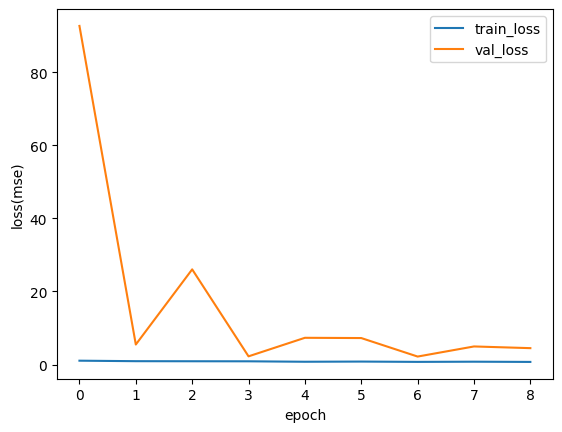

In [24]:
#mse
plt.plot(loss_plot[1:], label='train_loss')
plt.plot(val_loss_plot[1:], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mse)')
plt.legend()
plt.show()

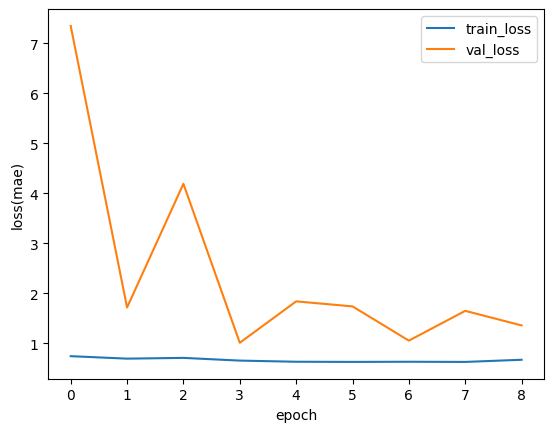

In [25]:
#mae
plt.plot(maeloss_plot[1:], label='train_loss')
plt.plot(maeval_loss_plot[1:], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

In [26]:
y_predicted#, label[75:]
y_predicted_concat = torch.cat([y_predicted[0], y_predicted[1], y_predicted[2], y_predicted[3]], dim = 0)

In [27]:
y_predicted_concat

tensor([[2.1399e-01, 3.3348e+01, 1.6924e+00, 2.8670e+01, 7.5410e+01],
        [2.4683e-01, 3.1869e+01, 2.3634e+00, 2.9005e+01, 7.4381e+01],
        [2.2132e-01, 3.3156e+01, 2.1738e+00, 2.8897e+01, 7.5456e+01],
        [2.1936e-01, 3.3241e+01, 1.4021e+00, 2.8777e+01, 7.5573e+01],
        [1.4700e-01, 3.4157e+01, 1.1513e+00, 2.9199e+01, 7.7073e+01],
        [3.0774e-01, 3.1157e+01, 3.1522e+00, 2.8518e+01, 7.2964e+01],
        [2.3699e-01, 3.2104e+01, 2.3858e+00, 2.8767e+01, 7.4289e+01],
        [2.4347e-01, 3.2618e+01, 2.2802e+00, 2.8855e+01, 7.5142e+01],
        [2.2627e-01, 3.2887e+01, 2.1047e+00, 2.9084e+01, 7.5453e+01],
        [2.8665e-01, 3.1931e+01, 2.6191e+00, 2.8534e+01, 7.3962e+01],
        [1.7298e-01, 3.3690e+01, 1.6432e+00, 2.9187e+01, 7.6558e+01],
        [3.1190e-02, 3.2639e+01, 1.2610e+00, 3.0255e+01, 7.6678e+01],
        [3.1179e-01, 3.1542e+01, 3.2612e+00, 2.8406e+01, 7.3458e+01],
        [2.0812e-01, 3.2772e+01, 1.7614e+00, 2.8982e+01, 7.5214e+01],
        [2.2400e-01,

In [31]:
# y1_p = y_predicted_concat[:, 0].reshape(25,1).cpu()
# y2_p = y_predicted_concat[:, 1].reshape(25,1).cpu()
# y3_p = y_predicted_concat[:, 2].reshape(25,1).cpu()
# y4_p = y_predicted_concat[:, 3].reshape(25,1).cpu()
# y5_p = y_predicted_concat[:, 4].reshape(25,1).cpu()
# #정답치
# y1 = unnorm_label[75:, 0].reshape(25,1)
# y2 = unnorm_label[75:, 1].reshape(25,1)
# y3 = unnorm_label[75:, 2].reshape(25,1)
# y4 = unnorm_label[75:, 3].reshape(25,1)
# y5 = unnorm_label[75:, 4].reshape(25,1)



# one = np.hstack((y1_p, y1))
# two = np.hstack((y2_p, y2))
# three = np.hstack((y3_p, y3))
# four = np.hstack((y4_p, y4))
# five = np.hstack((y5_p, y5))


# scat_1 = [[x, y] for (x, y) in one]#zip(one[:,0], one[:,1])
# scat_2 = [[x, y] for (x, y) in two]#zip(one[:,0], one[:,1])
# scat_3 = [[x, y] for (x, y) in three]#zip(one[:,0], one[:,1])
# scat_4 = [[x, y] for (x, y) in four]#zip(one[:,0], one[:,1])
# scat_5 = [[x, y] for (x, y) in five]#zip(one[:,0], one[:,1])

wandb.init(project = )
table_1 = wandb.Table(data = scat_1, columns = ['predicted', 'truth'])
scatter_1 = wandb.plot.scatter(table_1, x = 'predicted', y = 'target', title = 'scat_1')

table_2 = wandb.Table(data = scat_2, columns = ['predicted', 'truth'])
scatter_2 = wandb.plot.scatter(table_2, x = 'predicted', y = 'target', title = 'scat_2')

table_3 = wandb.Table(data = scat_3, columns = ['predicted', 'truth'])
scatter_3 = wandb.plot.scatter(table_3, x = 'predicted', y = 'target', title = 'scat_3')

table_4 = wandb.Table(data = scat_4, columns = ['predicted', 'truth'])
scatter_4 = wandb.plot.scatter(table_4, x = 'predicted', y = 'target', title = 'scat_4')

table_5 = wandb.Table(data = scat_5, columns = ['predicted', 'truth'])
scatter_5 = wandb.plot.scatter(table_5, x = 'predicted', y = 'target', title = 'scat_5')

wandb.log({ 'scatter_1': scatter_1, 'scatter_2' : scatter_2, 'scatter_3' : scatter_3, 
'scatter_4' : scatter_4, 'scatter_5': scatter_5})


# x = np.arange(-0.05, 0.25, 0.05)
# plt.plot(x,x)
# plt.title("y1", fontsize = 15)
# plt.scatter( one[:,0], one[:, 1], color = 'blue', alpha = .5)
# # plt.scatter(n_1[:,0], n_1[:,1], color = 'red', alpha = .5)
# plt.grid()
# plt.show()

# x = np.arange(30, 38, 1)
# plt.plot(x, x)
# plt.title("y2", fontsize = 15)
# plt.scatter( two[:,0], two[:, 1], color = 'blue', alpha = .5)
# plt.grid()
# plt.show()



# x = np.arange(1, 6, 1)
# plt.plot(x, x)
# plt.title("y3", fontsize = 15)
# plt.scatter( three[:,0], three[:, 1], color = 'blue', alpha = .5)
# plt.grid()
# plt.show()



# x = np.arange(27, 34, 1)
# plt.plot(x, x)
# plt.title("y4", fontsize = 15)
# plt.scatter( four[:,0], four[:, 1], color = 'blue', alpha = .5)
# plt.grid()
# plt.show()

# x = np.arange(72, 82, 1)
# plt.plot(x, x)
# plt.title("y5", fontsize = 15)
# plt.scatter( five[:,0], five[:, 1], color = 'blue', alpha = .5)
# plt.grid()
# plt.show()
# wandb.finish()

Error: You must call wandb.init() before wandb.log()

In [30]:
scat_1

[[0.21399403, 0.0617],
 [0.24683207, 0.0279],
 [0.22131696, 0.0115],
 [0.21936426, 0.0376],
 [0.14700043, 0.008],
 [0.30774242, 0.0503],
 [0.23699106, 0.0799],
 [0.24347395, 0.0213],
 [0.22626981, 0.0768],
 [0.28665447, 0.01],
 [0.17298236, 0.072],
 [0.031190041, 0.0098],
 [0.31178555, 0.1616],
 [0.20811678, 0.0608],
 [0.22399825, 0.0766],
 [0.039505273, 0.0802],
 [0.25263128, 0.0807],
 [0.2527661, 0.0229],
 [0.18363532, 0.0536],
 [0.30296838, 0.067],
 [0.282708, 0.0419],
 [0.20949645, 0.0416],
 [0.17434454, 0.192],
 [0.23408678, 0.0199],
 [0.20441367, 0.052]]